## Setting

We consider the following setting. Let $S_n = \{Z_1,\ldots,Z_n\}$ where $Z_i=(x_i,y_i) \in \mathcal{X}
\times \mathcal{Y}$ is a pair of feature-label.

We are interested in the linear regression problem. We assume that there exists a parameter space $\Theta$ and an underlying parameter $\theta^* \in \Theta$ such that $y_i = \langle x_i,\theta^*\rangle+\epsilon_i.$ 

We consider the squared loss defined as $\ell(\theta,x,y) = \frac{1}{2}(y-\langle x,\theta\rangle)^2.$ To simplify notation we will denote $\ell_i(\theta) = \ell(\theta,x_i,y_i).$
The learning problem consists in having a good estimate of $\theta^*.$ This problem is among the most famous learning problem and therefore enjoys a lot of knowns results. Especially if we define the Empirical Risk Minimizer (ERM) as:
$$\widehat \theta_n := \arg \min_{\theta \in \Theta} \frac{1} {n}\mathcal{L}_n(\theta) = \arg \min_{\theta \in \Theta} ||x_{1:n}\theta - y_{1:n}||_2^2$$
where $\mathcal{L}_n(\theta)=\sum_{t=1}^n \ell_t(\theta)$.
We know that $\widehat\theta_n = (x_{1:n}^Tx_{1:n})^{-1}x_{1:n}^T y_{1:n}$ where for all $t$, $x_{1:t}$ is the matrix whose rows are $x_1^T,...,x_t^T$ and $y_{1:t}=(y_1,...,y_t)^T.$

#### Assumption:
There exists a non-increasing sequence $(\phi_d)_{d \in \mathbb{N}^*}$ of non-negative real numbers such that, for all $t \in \mathbb{N}^*$:
    $$\mathbb{E}\left[\mathbb{E}_{\epsilon' \sim \mu}[\epsilon']-\epsilon_t \Big| \mathcal{F}_{t-d}\right] \leq \phi_d\,,$$
    where $\epsilon'$ being independent on the process $(\epsilon_t)_{t\in\mathbb N^*}$ and having as distribution the stationary marginal $\mu$.   

To simplify the analysis let $n=dK$ and define for all $i\in [d]$
$$\widehat \theta_K^{(i)} = \arg \min_{\theta} || x_{1:K}^{(i)}\theta - y_{1:K}^{(i)}||_2^2$$
where $x_{1:K}^{(i)}$ is the matrix whose rows are $x_i^T,x_{i+d}^T,\ldots,x_{i+(K-1)d}^T$ and $y_{1:t}=(y_i,y_{i+d},\ldots,y_{i+(K-1)d})^T$

We consider the following estimator
$$\tilde \theta_n = \frac{1}{d}\sum_{i=1}^d\widehat \theta_K^{(i)}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest, norm, uniform

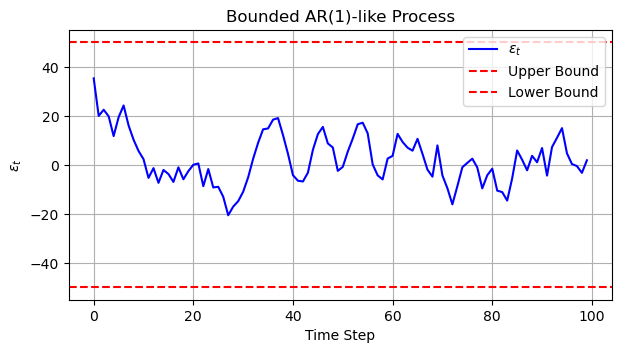

In [2]:
def generate_bounded_ar1(n, phi, c, epsilon_0=None):
    """
    Generate a bounded AR(1)-like process.

    Parameters:
    - n (int): Number of time steps to generate.
    - phi (float): AR(1) coefficient, must satisfy |phi| < 1.
    - c (float): Uniform noise bound, Z_t ~ Uniform[-c, c].
    - epsilon_0 (float): Initial value of the process. If None, it will be drawn from the stationary distribution.

    Returns:
    - epsilon (numpy array): Generated AR(1)-like process.
    """
    if not (0 <= phi < 1):
        raise ValueError("phi must satisfy 0 <= phi < 1.")
    if c <= 0:
        raise ValueError("c must be positive.")

    # Compute the stationary bound
    stationary_bound = c / (1 - phi)

    # Initialize the process
    epsilon = np.zeros(n)
    if epsilon_0 is None:
        epsilon[0] = np.random.uniform(-stationary_bound, stationary_bound)  # Start from the stationary distribution
    else:
        epsilon[0] = epsilon_0

    # Generate the process
    for t in range(1, n):
        Z_t = np.random.uniform(-c, c)
        epsilon[t] = np.random.normal(phi * epsilon[t-1] + Z_t)

    return epsilon

# Parameters
n = 100  # Number of steps
phi = 0.8  # AR(1) coefficient
c = 10.0  # Uniform noise bound

# Generate the process
epsilon = generate_bounded_ar1(n, phi, c)

# Plot the process
plt.figure(figsize=(7, 3.5))
plt.plot(epsilon, label=r"$\epsilon_t$", color="blue")
plt.axhline(y=c/(1-phi), color="red", linestyle="--", label="Upper Bound")
plt.axhline(y=-c/(1-phi), color="red", linestyle="--", label="Lower Bound")

plt.title("Bounded AR(1)-like Process")
plt.xlabel("Time Step")
plt.ylabel(r"$\epsilon_t$")
plt.legend()
plt.grid()
plt.show()

In [3]:
def SimulateAR1(phi, sigma, n):

    # start from arbitrarly poinr
    x = np.random.random(size=(n,))
    for t in range(1, n):
        x[t] = np.random.normal(phi * x[t-1], sigma)
    return x

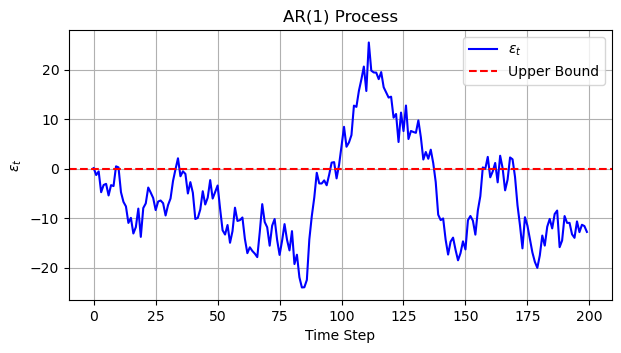

In [25]:
epsilon = SimulateAR1(phi=0.95, sigma=3, n=200)

plt.figure(figsize=(7, 3.5))
plt.plot(epsilon, label=r"$\epsilon_t$", color="blue")
plt.axhline(y=0, color="red", linestyle="--", label="Upper Bound")

plt.title("AR(1) Process")
plt.xlabel("Time Step")
plt.ylabel(r"$\epsilon_t$")
plt.legend()
plt.grid()

In [4]:
from statsmodels.tsa.stattools import acf

def manual_ljungbox(residuals, lags=1):
    """Compute Ljung-Box test statistic manually for lag 1."""
    n = len(residuals)
    acf_vals = acf(residuals, nlags=lags, fft=False)
    r1 = acf_vals[1]
    Q = n * (n + 2) * (r1 ** 2) / (n - 1)
    p_value = 1 - norm.cdf(Q)
    return p_value



In [50]:
def generate_data(n, d, theta_star, noise_std=1.0, noise_type="gaussian"):
    """
    Generate data of the form y_t = <x_t, theta^*> + epsilon_t.

    Parameters:
    - n (int): Number of samples (time steps) to generate.
    - d (int): Dimensionality of x_t and theta^*.
    - theta_star (numpy array): True parameter vector of shape (d,).
    - noise_std (float): Standard deviation of the noise.
    - noise_type (str): Type of noise, either "gaussian" or "uniform".

    Returns:
    - X (numpy array): Generated feature matrix of shape (n, d).
    - y (numpy array): Generated target vector of shape (n,).
    """
    if theta_star.shape[0] != d:
        raise ValueError("theta_star must have the same dimension as d.")

    # Generate random feature matrix X (e.g., from a standard normal distribution)
    X = np.random.randn(n, d) # maybe normalize 

    # Generate noise
    if noise_type == "gaussian":
        epsilon = np.random.normal(0, noise_std, size=n)
    elif noise_type == "uniform":
        epsilon = np.random.uniform(-noise_std, noise_std, size=n)
    elif noise_type == "mixing":
        epsilon = SimulateAR1(phi=0.999, sigma=2, n=n) #generate_bounded_ar1(n, phi, c, epsilon_0=None)
    else:
        raise ValueError("Invalid noise_type. Choose 'gaussian' or 'uniform'.")

    # Compute y_t = <x_t, theta^*> + epsilon_t
    y = X @ theta_star + epsilon
    return X, y

In [6]:
def analyze_residuals(X, y, theta):
    """
    Analyze residuals to determine whether they are Gaussian or Uniform noise.

    Parameters:
    - X (numpy array): Feature matrix of shape (n, d).
    - y (numpy array): Target vector of shape (n,).
    - theta (numpy array): Parameter vector of shape (d,).

    Returns:
    - result (str): "Gaussian" or "Uniform", indicating the best fit.
    - stats (dict): Contains p-values and fitted parameters for both models.
    """
    # Step 1: Compute residuals
    residuals = y - X @ theta

    # Step 2: Fit Gaussian model
    mu_gaussian = np.mean(residuals)
    sigma_gaussian = np.std(residuals)
    gaussian_pvalue = kstest(residuals, lambda x: norm.cdf(x, loc=mu_gaussian, scale=sigma_gaussian)).pvalue

    # Step 3: Fit Uniform model
    a_uniform, b_uniform = np.min(residuals), np.max(residuals)
    uniform_pvalue = kstest(residuals, lambda x: uniform.cdf(x, loc=a_uniform, scale=b_uniform - a_uniform)).pvalue
    
    #Step4 : Fit Mixing model
    residuals_lagged = residuals[:-1]
    residuals_current = residuals[1:]
    phi_hat = np.sum(residuals_lagged * residuals_current) / np.sum(residuals_lagged ** 2)
    # Test for serial correlation using Ljung-Box Q-test
    lb_pvalue = manual_ljungbox(residuals, lags=1)
    
    # Step 5: Decide the best fit
    if lb_pvalue < 0.05:  # Significant serial correlation
        result = "Mixing"
    elif gaussian_pvalue > uniform_pvalue:
        result = "Gaussian"
    else:
        result = "Uniform"

    # Return results
    stats = {
        "Gaussian": {"p-value": gaussian_pvalue, "mean": mu_gaussian, "std": sigma_gaussian},
        "Uniform": {"p-value": uniform_pvalue, "min": a_uniform, "max": b_uniform},
        "Mixing": {"p-value": lb_pvalue, "phi": phi_hat},
    }
    return result, stats

In [7]:


def analyze_residuals(X, y, theta):
    """
    Analyze residuals to determine if they are Gaussian, Uniform, or Mixing noise.

    Parameters:
    - X (numpy array): Feature matrix of shape (n, d).
    - y (numpy array): Target vector of shape (n,).
    - theta (numpy array): Parameter vector of shape (d,).

    Returns:
    - result (str): "Gaussian", "Uniform", or "Mixing", indicating the best fit.
    - stats (dict): Contains p-values and fitted parameters for all models.
    """
    # Step 1: Compute residuals
    residuals = y - X @ theta
    n = len(residuals)

    # Step 2: Fit Gaussian model
    mu_gaussian = np.mean(residuals)
    sigma_gaussian = np.std(residuals)
    gaussian_pvalue = kstest(residuals, lambda x: norm.cdf(x, loc=mu_gaussian, scale=sigma_gaussian)).pvalue

    # Step 3: Fit Uniform model
    a_uniform, b_uniform = np.min(residuals), np.max(residuals)
    uniform_pvalue = kstest(residuals, lambda x: uniform.cdf(x, loc=a_uniform, scale=b_uniform - a_uniform)).pvalue

    # Step 4: Test for Mixing (AR(1)-like process)
    # Fit an AR(1) model: residuals_t = phi * residuals_{t-1} + noise
    residuals_lagged = residuals[:-1]
    residuals_current = residuals[1:]
    phi_hat = np.sum(residuals_lagged * residuals_current) / np.sum(residuals_lagged ** 2)
    # Test for serial correlation using Ljung-Box Q-test
    lb_pvalue = manual_ljungbox(residuals, lags=10)

    # Decision
    if lb_pvalue < 0.05:  # Significant serial correlation
        result = "Mixing"
    elif gaussian_pvalue > uniform_pvalue:
        result = "Gaussian"
    else:
        result = "Uniform"

    # Collect stats for each model
    stats = {
        "Gaussian": {"p-value": gaussian_pvalue, "mean": mu_gaussian, "std": sigma_gaussian},
        "Uniform": {"p-value": uniform_pvalue, "min": a_uniform, "max": b_uniform},
        "Mixing": {"p-value": lb_pvalue, "phi": phi_hat},
    }

    return result, stats

In [31]:
# Generate data
n = 100  # Number of samples
d = 5    # Dimensionality
theta_star = np.random.uniform(-3, 3, size=d)  # True parameter vector
noise_std = 1  # Standard deviation of the noise
X, y = generate_data(n, d, theta_star, noise_std, noise_type="mixing")
analyze_residuals(X, y, theta=theta_star)

('Mixing',
 {'Gaussian': {'p-value': 0.024740246632911345,
   'mean': 0.025243196746958123,
   'std': 1.2647431273666572},
  'Uniform': {'p-value': 1.948711395590051e-09,
   'min': -4.036421529419083,
   'max': 2.482927663887432},
  'Mixing': {'p-value': 0.0, 'phi': 0.7636489053071315}})

In [8]:
def closed_form_ERM(X, y):
    """
    Compute the parameter vector using the closed-form solution (Normal Equation) for linear regression.
    
    Parameters:
    - X (numpy array): Feature matrix of shape (n, d).
    - y (numpy array): Target vector of shape (n,).
    
    Returns:
    - theta (numpy array): The learned parameter vector of shape (d,).
    """
    # Compute the closed-form solution (Normal Equation)
    theta = np.linalg.inv(X.T @ X) @ X.T @ y
    return theta

def segmented_ERM(X, y, p, d, K):
    """
    Compute the segmented ERM estimator where n = d*K and the data is partitioned into blocks for each lag.
    
    Parameters:
    - X (numpy array): Feature matrix of shape (n, p), where p is the dimension of theta.
    - y (numpy array): Target vector of shape (n,).
    - p (int): Dimension of the feature space (i.e., the length of theta).
    - d (int): Number of lags.
    - K (int): Number of blocks.
    
    Returns:
    - theta_K (numpy array): The learned parameters for all blocks, shape (p, d).
    """
    n = len(y)
    assert n == d * K, "n must be equal to d*K"
    
    theta_K = np.zeros((p, d))  # Initialize a matrix to store learned parameters for each lag
    
    # Loop through each lag (i.e., each feature index)
    for i in range(d):
        # Create the block matrix X_{1:K}^{(i)} for lag i
        X_block = np.zeros((K, p))  # (K, p) matrix for each block (with p features)
        
        for j in range(K):
            X_block[j,] = X[i + j*d,]  # Collecting x_i, x_{i+d}, ...
        
        # Create the target vector y_{1:K}^{(i)}
        y_block = y[i::d][:K]  # Every d-th element starting from i
        
        # Compute the closed-form solution for this block
        theta_K[:, i] = closed_form_ERM(X_block, y_block)
        
    return np.mean(theta_K,axis=1)

In [33]:
# Function definitions (assuming the ones you have)
# - generate_data, closed_form_ERM, and segmented_ERM functions should be defined earlier.

n = 100  # Number of samples
p = 10    # Dimensionality
theta_star = np.random.uniform(-2, 2, size=p)  # True parameter vector
noise_std = 1  # Standard deviation of the noise

# Generate data
X, y = generate_data(n, p, theta_star, noise_std, noise_type="mixing") 

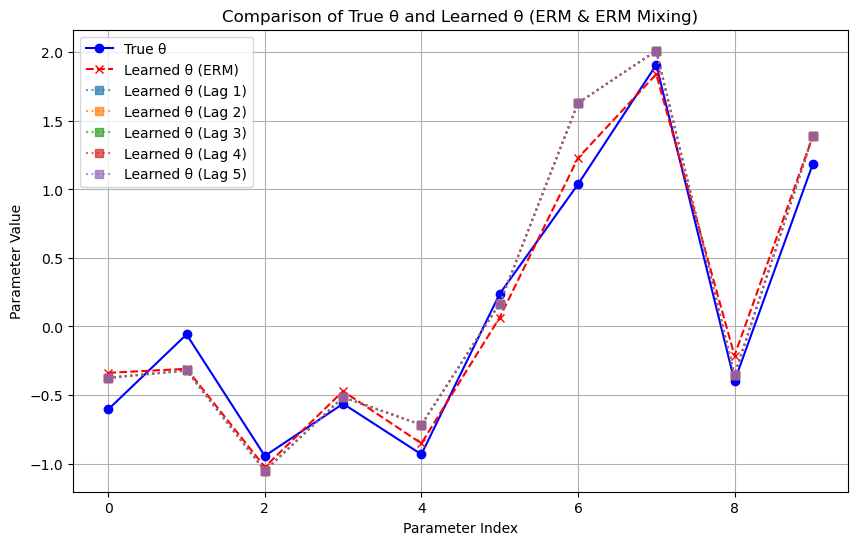

Final empirical risk (MSE) for ERM: 2.5038
Final empirical risk (MSE) for ERM Mixing: 2.7802


In [35]:
d = 5# the lag
K = n // d
## Compute the ERM (closed-form solution)
theta_ERM = closed_form_ERM(X, y)

# Compute the segmented ERM (mixing model)
theta_ERM_mixing = segmented_ERM(X, y, p, d, K)

# Plot comparison between true theta and learned theta
plt.figure(figsize=(10, 6))

# Plot True θ
plt.plot(range(p), theta_star, label='True θ', marker='o', linestyle='-', color='blue')

# Plot Learned θ (ERM)
plt.plot(range(p), theta_ERM, label='Learned θ (ERM)', marker='x', linestyle='--', color='red')

# Plot Learned θ for each lag (ERM_Mixing)
for i in range(d):
    plt.plot(range(p), theta_ERM_mixing, label=f'Learned θ (Lag {i+1})', marker='s', linestyle=':', alpha=0.7)

# Title and labels
plt.title('Comparison of True θ and Learned θ (ERM & ERM Mixing)')
plt.xlabel('Parameter Index')
plt.ylabel('Parameter Value')
plt.legend()
plt.grid(True)
plt.show()

# Compute the empirical risk (MSE) for the learned theta (ERM)
predictions_ERM = X @ theta_ERM
mse_ERM = np.mean((y - predictions_ERM) ** 2)
print(f"Final empirical risk (MSE) for ERM: {mse_ERM:.4f}")

# Compute the empirical risk (MSE) for the learned theta (ERM_Mixing)
predictions_ERM_mixing = X @ theta_ERM_mixing
mse_ERM_mixing = np.mean((y - predictions_ERM_mixing) ** 2)
print(f"Final empirical risk (MSE) for ERM Mixing: {mse_ERM_mixing:.4f}")

In [182]:
theta_ERM

array([ 1.90839713, -0.23144357, -0.58690868,  2.59409086,  2.50294291,
       -2.65312999, -2.81828822,  1.79822303,  0.3195752 , -2.33954171])

In [55]:
n = 200  # Number of samples
p = 5    # Dimensionality
theta_star = np.random.uniform(-2, 2, size=p)  # True parameter vector
noise_std = 1  # Standard deviation of the noise

# Generate data
X, y = generate_data(n, p, theta_star, noise_std, noise_type="mixing") 

res_ = {}

## Compute the ERM (closed-form solution)
theta_ERM = closed_form_ERM(X, y)

#predictions_ERM = X @ theta_ERM
#mse_ERM = np.mean((y - predictions_ERM) ** 2)
#print(f"Final empirical risk (MSE) for ERM: {mse_ERM:.4f}")

# Compute the segmented ERM (mixing model)
for d in [1, 2, 4, 5]:

    K = n // d
    theta_ERM_mixing = segmented_ERM(X, y, p, d, K)

    # Compute the empirical risk (MSE) for the learned theta (ERM_Mixing)
    predictions_ERM_mixing = X @ theta_ERM_mixing
    mse_ERM_mixing = np.mean((y - predictions_ERM_mixing) ** 2)

    print(f"Final empirical risk (MSE) for our estimator with d = {d}: {mse_ERM_mixing:.4f}")
    res_[d] = mse_ERM_mixing


Final empirical risk (MSE) for our estimator with d = 1: 39.5950
Final empirical risk (MSE) for our estimator with d = 2: 39.5987
Final empirical risk (MSE) for our estimator with d = 4: 39.6630
Final empirical risk (MSE) for our estimator with d = 5: 39.6305


Text(0, 0.5, 'MSE')

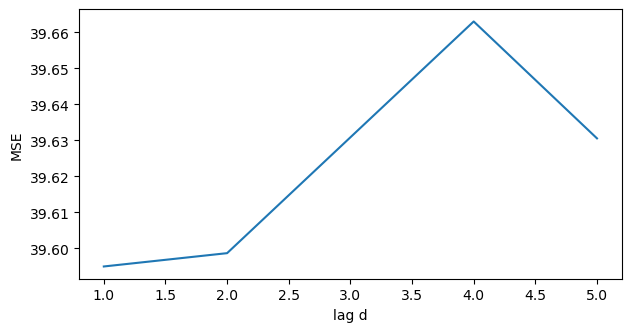

In [56]:
plt.figure(figsize=(7, 3.5))
plt.plot(res_.keys(), res_.values())
plt.xlabel('lag d')
plt.ylabel('MSE')

In [10]:
n

500

In [11]:
d*K

200